<a href="https://colab.research.google.com/github/Harshtherocking/colab-lab/blob/main/GradCam-ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VIT

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

from PIL import Image
import torch.nn.functional as F

from torchvision import transforms, models
import urllib.request
import numpy as np

## prep

In [9]:
def preprocess_image(img_path):
    """Load and preprocess images for PyTorch models."""
    img = Image.open(img_path).convert("RGB")
    #Transforms used by imagenet models
    transform = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.Resize((384,384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(img).unsqueeze(0)

In [10]:
def process_grad (grad) :
  g = np.copy(grad)

  if len(g.shape) >= 3 :
    g = np.transpose(g, (1,2,0))

  g = np.maximum(0, g)

  g -= np.min(g)
  g /= (np.max(g) + 1e-9)
  return g


## model loading

In [11]:
from torchvision.models import ViT_B_16_Weights
vit= models.vit_b_16(ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)

In [12]:
vit.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Standard Backprop

In [13]:
img1 = preprocess_image("34.jpg")
img2 = preprocess_image("100.jpg")

In [14]:
img_tensor = img2.clone()
img_tensor.requires_grad = True

In [15]:
pred = vit(img_tensor)
pred.shape

torch.Size([1, 1000])

In [16]:
pred.argmax()

tensor(100)

In [17]:
y = pred.argmax()

pred[:, y].backward()

In [18]:
img_tensor.grad.shape

torch.Size([1, 3, 384, 384])

In [19]:
grad = img_tensor.grad.detach().cpu().numpy()
grad.shape

(1, 3, 384, 384)

In [20]:
pro_grads = process_grad(grad.squeeze())

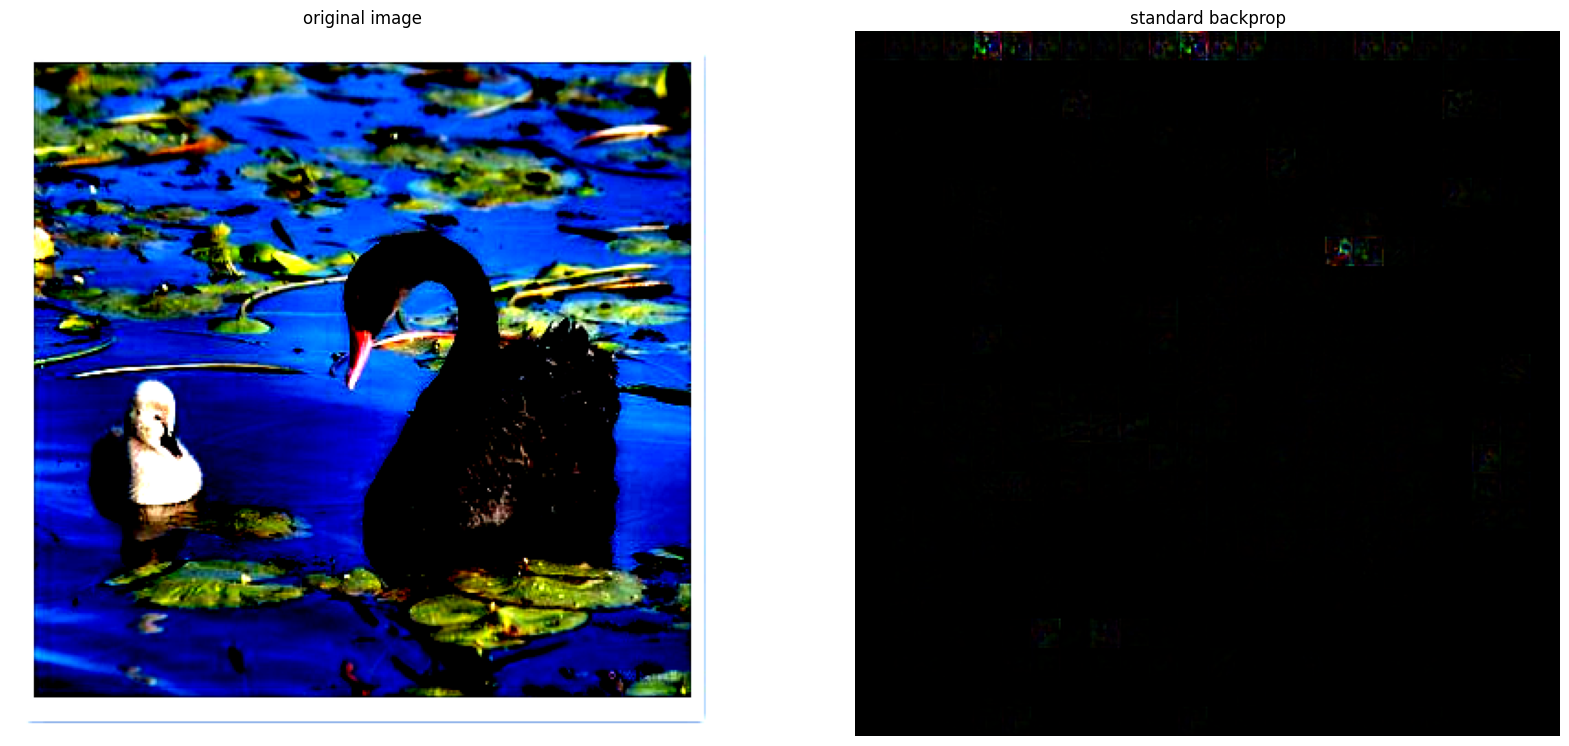

In [21]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(img2.squeeze().permute(1,2,0))
plt.title ("original image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(pro_grads)
plt.title ("standard backprop")
plt.axis("off")
plt.show()

## collecting grad for class token and then interpolating it



In [22]:
A = []
def forward_hook_A (module, input, output):
  for act in output :
    if act is not None :
      A.append(act.detach().cpu().numpy())
  return


dydA = []
def backward_hook_A (module, grad_in, grad_out):
  for grad in grad_out  :
    if grad is not None :
      dydA.append(grad.detach().cpu().numpy())
  return

In [23]:
layer = vit.encoder.layers.encoder_layer_10.ln_2
layer

LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [24]:
frwd_handle = layer.register_forward_hook(forward_hook_A)
bwd_handle = layer.register_full_backward_hook(backward_hook_A)

In [25]:
vit.zero_grad()
img_tensor =  img2.clone()
pred = vit(img_tensor)
y = pred.argmax()
print(f"pred class : {y}")

pred class : 100


In [26]:
pred[:, y].backward()

In [27]:
print(f"Activation : {A}\n\n\nGradient wrt to Activation : {dydA}")

Activation : [array([[-0.91167134,  1.8331662 , -0.09878382, ...,  1.3516545 ,
         0.10801093,  0.41823846],
       [-0.53450614,  0.7455643 , -0.61995596, ...,  0.7058125 ,
        -0.4702405 ,  0.00321253],
       [-1.4137686 ,  0.42439395, -0.8621066 , ...,  0.72328   ,
        -0.7747957 , -0.8186833 ],
       ...,
       [-0.7354613 , -0.10650915, -0.717727  , ...,  0.70458835,
        -0.12391715, -0.20025438],
       [-0.8150085 ,  0.01415412, -0.6709828 , ...,  0.7199851 ,
        -0.09538382, -0.27855378],
       [-1.3598542 , -0.1192379 , -0.65620315, ...,  0.9832309 ,
        -0.01969078, -0.19233376]], dtype=float32)]


Gradient wrt to Activation : [array([[[-1.70780960e-02, -5.23082912e-03, -2.57046893e-02, ...,
          3.16141769e-02,  2.81245448e-05,  2.16445103e-02],
        [ 2.31751601e-05,  4.41271295e-05,  9.81407265e-06, ...,
         -3.63886284e-06,  1.71469219e-05,  3.71256137e-05],
        [ 3.01886263e-04, -2.54225190e-04,  8.11989885e-05, ...,
        

In [28]:
A[0].shape

(577, 768)

In [29]:
dydA[0].shape

(1, 577, 768)

In [30]:
A = A[0]
dydA = dydA[0][0]
dydA.shape

(577, 768)

In [31]:
alpha  = dydA.sum(axis = 0) / dydA.shape[0]
alpha.shape

(768,)

In [32]:
heatmap = alpha * A
heatmap  = heatmap.sum(axis = 1)

# applying relu
heatmap = np.maximum(0, heatmap)
heatmap.shape

(577,)

In [33]:
def heatmap_to_image(heatmap) :
  # remove class tokens
  heatmap = heatmap[1:]

  #  compute patches per row/col
  num_patches = heatmap.shape[0]
  grid_size= int(np.sqrt(num_patches))

  assert grid_size * grid_size == num_patches,  "num patches not a perfect square"

  # reshape to (H, W)
  img = heatmap.reshape(grid_size, grid_size)

  return img

In [34]:
heatmap_img = heatmap_to_image(heatmap)
heatmap_img.shape

(24, 24)

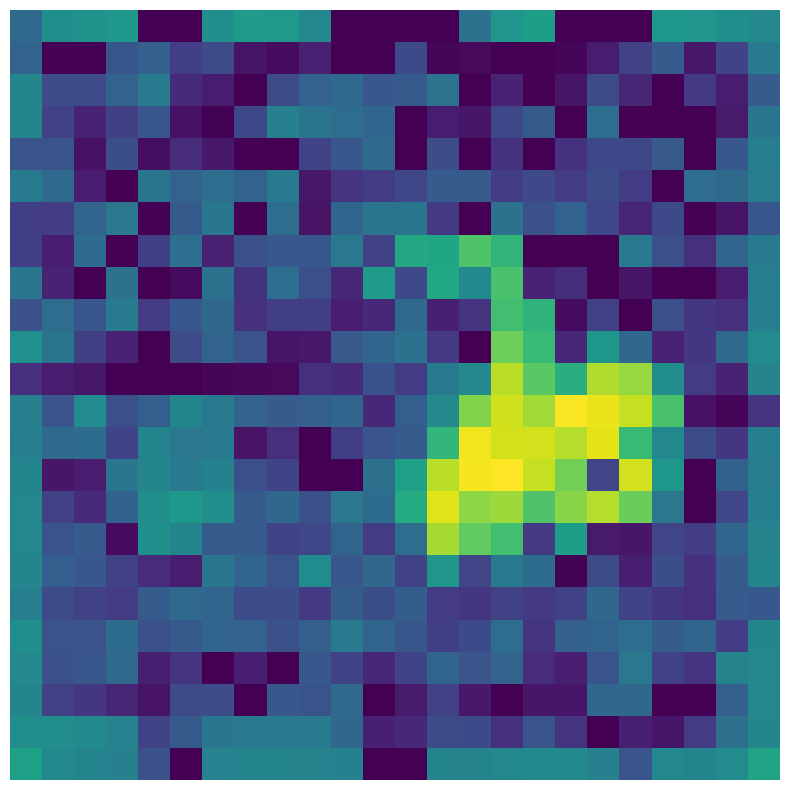

In [51]:
figure  = plt.figure(figsize = (10,10))
plt.imshow(heatmap_img)
plt.axis("off")
plt.show()

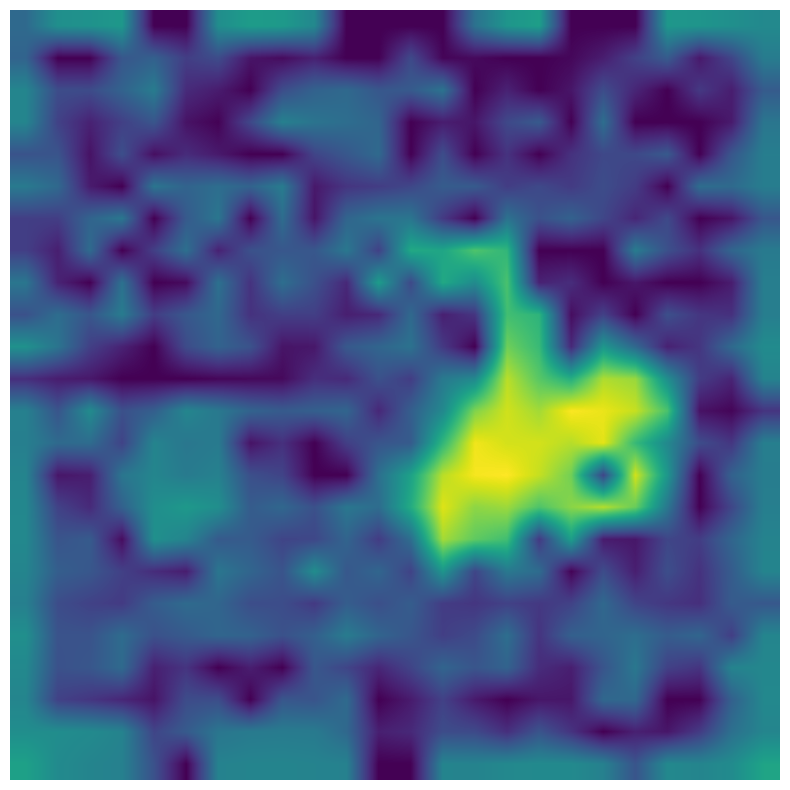

In [50]:
figure  = plt.figure(figsize = (10,10))
plt.imshow(heatmap_img, interpolation="bilinear")
plt.axis("off")
plt.show()